In [1]:
import torch
import numpy as np
from sbi.inference import prepare_for_sbi, SNLE
from sbi.simulators.linear_gaussian import diagonal_linear_gaussian
import sbi.utils as sbi_utils

pyknos/nflows/nn/nde


### Load theta and x

In [2]:
data = np.load('../results/cleaned_up_data2.npz', allow_pickle=True)

x = torch.as_tensor(data['data'], dtype=torch.float32)
theta = torch.as_tensor(data['params'], dtype=torch.float32)

In [3]:
x.shape

torch.Size([1992007, 35])

In [4]:
import sys
sys.path.append('../')

In [5]:
from parameter_setup import load_ground_truth_params, load_prior_min, load_prior_max

### Load data to standardize - needed to standardize x_o

In [6]:
#standardize_vals = np.load('../results/standardize_vals.npz')
#x_mean = standardize_vals['data_mean']
#x_std = standardize_vals['data_std']
#
#theta_mean = standardize_vals['theta_mean']
#theta_std = standardize_vals['theta_std']

x_mean = x.mean(dim=0)
x_std = x.std(dim=0)

theta_mean = theta.mean(dim=0)
theta_std = theta.std(dim=0)

In [7]:
x = (x-x_mean) / x_std
theta = (theta-theta_mean) / theta_std

### Load x_o (which I got from running the simulator with Arco's ground truth params)

In [8]:
import numpy as np
x_o = torch.as_tensor(np.load('../results/observation/x_o_new_ss.npz')['x_o'], dtype=torch.float32)

x_o = (x_o - x_mean) / x_std
x_o = x_o.unsqueeze(0)

### Create dummy simulator and dummy prior

In [9]:
def dummy_simulator(theta):
    return torch.ones(1,35)

dummy_prior = sbi_utils.BoxUniform(torch.as_tensor(load_prior_min()), torch.as_tensor(load_prior_max()))
_bound = torch.sqrt(torch.as_tensor(3.))
dummy_prior_norm = sbi_utils.BoxUniform(-_bound*torch.ones(35), _bound*torch.ones(35))

In [10]:
from sbi.utils.get_nn_models import likelihood_nn

In [11]:
simulator, prior, x_shape = prepare_for_sbi(dummy_simulator, dummy_prior_norm)

nsf = likelihood_nn(
    model='nsf',
    theta_shape=prior.sample().shape,
    x_o_shape=x_shape,
    hidden_features=200,
    flow_num_transforms=10,
)

In [37]:
inference = SNLE(
    simulator, 
    prior,
    x_shape,
    external_data=(theta, x), # todo: remove the [:1000] to train on all datasamples
    mcmc_method='slice', 
    density_estimator=nsf
)

In [38]:
posterior = inference(
    num_rounds=1,
    num_simulations_per_round=0,
    batch_size=100, # default is 50
    stop_after_epochs=10, # default is 20
)

Neural network successfully converged after 61 epochs.


In [39]:
import pickle
#with open('../results/posteriors/200619_PosteriorSNL.pickle', 'wb') as handle:
#    pickle.dump(posterior, handle)

### Run VI

In [14]:
from sbi.utils.get_nn_models import get_vi_net
from sbi.utils.vi import train_vi, train_mle
import torch
import sbi.utils as utils

In [15]:
import sys
sys.path.append('../../../bFlows')
from bflows.utils.neural_net.get_bounded_flows import get_bflow

In [44]:
vi_net = get_vi_net(parameter_dim=35)

In [45]:
posterior = posterior.set_default_x(x_o)

In [46]:
vi_net_ = get_bflow('nsf_uncond_bounded', prior=prior, context=x_o, num_coupling=10, hidden_features=200)
trained_vi_net = train_vi(vi_net_, posterior, batch_size=500, stop_after_epochs=50)

loss:    tensor(288.1560, grad_fn=<MeanBackward0>)
loss:    tensor(282.3391, grad_fn=<MeanBackward0>)
loss:    tensor(277.1024, grad_fn=<MeanBackward0>)
loss:    tensor(277.8388, grad_fn=<MeanBackward0>)
loss:    tensor(276.3999, grad_fn=<MeanBackward0>)
loss:    tensor(271.5084, grad_fn=<MeanBackward0>)
loss:    tensor(266.5534, grad_fn=<MeanBackward0>)
loss:    tensor(258.0864, grad_fn=<MeanBackward0>)
loss:    tensor(246.4940, grad_fn=<MeanBackward0>)
loss:    tensor(242.9842, grad_fn=<MeanBackward0>)
loss:    tensor(233.4880, grad_fn=<MeanBackward0>)
loss:    tensor(225.9792, grad_fn=<MeanBackward0>)
loss:    tensor(214.7915, grad_fn=<MeanBackward0>)
loss:    tensor(203.1809, grad_fn=<MeanBackward0>)
loss:    tensor(194.5982, grad_fn=<MeanBackward0>)
loss:    tensor(189.3927, grad_fn=<MeanBackward0>)
loss:    tensor(174.6635, grad_fn=<MeanBackward0>)
loss:    tensor(167.0130, grad_fn=<MeanBackward0>)
loss:    tensor(161.6831, grad_fn=<MeanBackward0>)
loss:    tensor(156.1572, grad_

In [47]:
import pickle
with open('../results/posteriors/200622_PosteriorSNL_VI_bigger_net.pickle', 'wb') as handle:
    pickle.dump(trained_vi_net, handle)

### Analyse posterior

In [16]:
import pickle
with open('../results/posteriors/200619_PosteriorSNL.pickle', 'rb') as handle:
    posterior = pickle.load(handle)

In [17]:
import pickle
with open('../results/posteriors/200622_PosteriorSNL_VI_bigger_net.pickle', 'rb') as handle:
    trained_vi_net = pickle.load(handle)

In [18]:
s = []
num_iter = 10
num_samples_per_iter = 100

for k in range(num_iter):
    print("new iter,", k)
    samples = trained_vi_net.sample(num_samples_per_iter).detach()

    # denormalize the samples
    samples = samples * theta_std + theta_mean

    # convert to list for pickling
    samples_list = samples.numpy().tolist()
    
    s.append(samples_list)
s = np.asarray(s)
s = s.reshape(num_iter*num_samples_per_iter, -1)

new iter, 0
new iter, 1
new iter, 2
new iter, 3
new iter, 4
new iter, 5
new iter, 6
new iter, 7
new iter, 8
new iter, 9


In [19]:
s_list = s.tolist()

In [20]:
print(s_list[0])

[153.89227294921875, 0.0027115624397993088, 372.8607177734375, 0.010375545360147953, 69.41265869140625, 0.048087283968925476, 0.0026321839541196823, 0.0006303301779553294, 0.0004713560629170388, 0.0791434645652771, 0.005769587121903896, 0.0015482520684599876, 0.0005826402339152992, 0.6991331577301025, 0.8772251009941101, 0.07872308790683746, 0.09880457818508148, 0.016081983223557472, 3.8968148231506348, 1.993944525718689, 0.004224236123263836, 0.0005351114086806774, 0.0011797824408859015, 0.032208073884248734, 0.0747133120894432, 0.01910850591957569, 0.3716028034687042, -1.5042496919631958, 0.5754405856132507, 1.4862384796142578, 3.199645652784966e-05, 3.615632886067033e-05, 4.4804663048125803e-05, 2.8752843718393706e-05, 1.2623975276947021]


In [35]:
#with open('../results/samples/200622_PosteriorSNL_VI_samples.pickle', 'wb') as handle:
#    pickle.dump(s_list, handle, protocol=2)

In [36]:
gt_params = [137.862136034238,
 0.0005793520824526776,
 199.1298048149789,
 0.0006108049075983062,
 152.1647419393015,
 0.00742430653684668,
 0.0010965218089651857,
 0.0008186770602065786,
 0.00011435310571497434,
 0.0022763084379226854,
 0.0036986082079423594,
 0.00013883334761566004,
 3.2474860530531394e-06,
 0.005426837416265438,
 0.10568666421909532,
 0.04812676692103998,
 0.094826660872338,
 0.013854989311151315,
 3.9010342040060975,
 3.8851157748263354,
 0.009964343408409574,
 0.006000497448875096,
 0.0012602755616811401,
 0.01392240648099882,
 0.06283710421562513,
 6.68382138396179e-05,
 0.08311048073340864,
 -2.9836949894223825,
 1.9642986130169147,
 1.2999358521956366,
 4.4931548434199036e-05,
 2.062212836678345e-05,
 4.22059843297412e-05,
 2.2409802171891654e-05,
 1.7109080877160283]

In [52]:
gt_params_norm = (torch.as_tensor(gt_params) - theta_mean) / theta_std

In [60]:
samples = trained_vi_net.sample(10000).detach()

In [65]:
probs = np.exp(posterior.log_prob(samples, x=x_o).detach().numpy())
prob_of_gt = np.exp(posterior.log_prob(gt_params_norm.unsqueeze(0), x=x_o).detach().numpy())

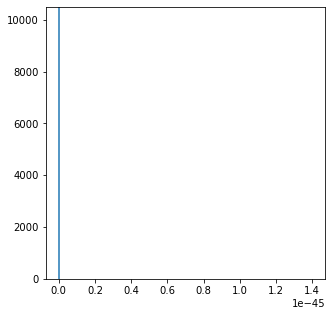

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(5,5))
_ = plt.hist(probs, bins=100)
ax.axvline(prob_of_gt)

In [51]:
dummy_prior_norm.log_prob(gt_params_norm.unsqueeze(0))

tensor([-43.4859])

### Posterior predictives
Has to be done in a different virtual env with python 2.